In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import ipywidgets as widgets
import requests
import random
import time
import matplotlib.dates as mdates
import itertools

# Importing encoders
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Import for string manipulation
import nltk
import string
import re


# Time Series Imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


# To increase the visible rows & cols
pd.options.display.max_rows = 2500
pd.options.display.max_columns = 15000

# Data Import & Cleaning

In [160]:
current_directory = os.getcwd()
file_path = os.path.join(current_directory, '../data/wallstreetbets_top_test.csv')
df_wsb = pd.read_csv(file_path)
file_path2 = os.path.join(current_directory, '../data/investing_top_test.csv')
df_invt = pd.read_csv(file_path2)

# List of companies trading in NYSE and NASDAQ
nyse_df = pd.read_csv('../data/nyse_screener.csv')
nasdaq_df = pd.read_csv('../data/nasdaq_screener.csv')

In [161]:
# Select only 'Symbol' and 'Name from both stockmarket dataframe
nyse_subset = nyse_df[['Symbol', 'Name']]
nasdaq_subset = nasdaq_df[['Symbol', 'Name']]

# Concatenate the subsets
stockmarket_df = pd.concat([nyse_subset, nasdaq_subset], ignore_index= True)

In [162]:
stockmarket_df.tail()

,Symbol,Name
7301,ZVRA,Zevra Therapeutics Inc. Common Stock
7302,ZVSA,ZyVersa Therapeutics Inc. Common Stock
7303,ZYME,Zymeworks Inc. Common Stock
7304,ZYNE,Zynerba Pharmaceuticals Inc. Common Stock
7305,ZYXI,Zynex Inc. Common Stock


In [163]:
df_wsb.info()
df_wsb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        940 non-null    int64  
 1   Title             940 non-null    object 
 2   Post Text         103 non-null    object 
 3   ID                940 non-null    object 
 4   Score             940 non-null    int64  
 5   Upvote Ratio      940 non-null    float64
 6   Total Comments    940 non-null    int64  
 7   Created On        940 non-null    object 
 8   Post URL          940 non-null    object 
 9   Original Content  940 non-null    bool   
dtypes: bool(1), float64(1), int64(3), object(5)
memory usage: 67.1+ KB


,Unnamed: 0,Title,Post Text,ID,Score,Upvote Ratio,Total Comments,Created On,Post URL,Original Content
0,0,Times Square right now,NaN,l8rf4k,479217,0.99,13884,2021-01-30 18:00:38,https://v.redd.it/x64z70f7eie61,False
1,1,UPVOTE so everyone sees we got SUPPORT,NaN,l6wu59,335468,0.98,12896,2021-01-28 13:40:34,https://i.redd.it/sgoqy8nyt2e61.png,False
2,2,GME YOLO update — Jan 28 2021,NaN,l78uct,296778,0.98,23166,2021-01-28 21:06:23,https://i.redd.it/opzucppb15e61.png,False
3,3,GME YOLO month-end update — Jan 2021,NaN,l846a1,262028,0.97,20063,2021-01-29 21:04:45,https://i.redd.it/r557em3t5ce61.png,False
4,4,It’s treason then,NaN,l881ia,243637,0.98,4622,2021-01-29 23:40:59,https://i.redd.it/d3t66lv1yce61.jpg,False


In [164]:
df_invt.info()
df_invt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        702 non-null    int64  
 1   Title             702 non-null    object 
 2   Post Text         694 non-null    object 
 3   ID                702 non-null    object 
 4   Score             702 non-null    int64  
 5   Upvote Ratio      702 non-null    float64
 6   Total Comments    702 non-null    int64  
 7   Created On        702 non-null    object 
 8   Post URL          702 non-null    object 
 9   Original Content  702 non-null    bool   
dtypes: bool(1), float64(1), int64(3), object(5)
memory usage: 50.2+ KB


,Unnamed: 0,Title,Post Text,ID,Score,Upvote Ratio,Total Comments,Created On,Post URL,Original Content
0,0,Robinhood and other brokers literally blocking...,"See title. Can't buy these stocks on RH, but c...",l6wvia,26954,0.99,5416,2021-01-28 13:42:17,https://www.reddit.com/r/investing/comments/l6...,False
1,1,Historically it's way better to invest at mark...,"Found this 2018 article, interesting/fun fact:...",lhtodm,9349,0.98,707,2021-02-11 20:19:14,https://www.reddit.com/r/investing/comments/lh...,False
2,2,Jim Cramer Gave an Interview in 2006 on how th...,[https://www.reuters.com/article/cramer-interv...,l92fz7,9185,0.99,745,2021-01-31 02:36:58,https://www.reddit.com/r/investing/comments/l9...,False
3,3,Emotional involvement has never been this high...,"First of all, I can't wait to be berated in th...",la3bft,8077,0.88,2434,2021-02-01 13:42:51,https://www.reddit.com/r/investing/comments/la...,False
4,4,By popular demand: official “I hate Robinhood ...,"Honestly, I didn’t want to post this myself si...",l8nntv,7266,0.98,1947,2021-01-30 15:12:48,https://www.reddit.com/r/investing/comments/l8...,False


In [165]:
df_wsb.columns.tolist()

['Unnamed: 0',
 'Title',
 'Post Text',
 'ID',
 'Score',
 'Upvote Ratio',
 'Total Comments',
 'Created On',
 'Post URL',
 'Original Content']

In [166]:
print(df_wsb[df_wsb.duplicated()])

Empty DataFrame
Columns: [Unnamed: 0, Title, Post Text, ID, Score, Upvote Ratio, Total Comments, Created On, Post URL, Original Content]
Index: []


In [167]:
print(df_invt[df_invt.duplicated()])

Empty DataFrame
Columns: [Unnamed: 0, Title, Post Text, ID, Score, Upvote Ratio, Total Comments, Created On, Post URL, Original Content]
Index: []


In [168]:
df_wsb.isnull().sum().sort_values(ascending = False)

Post Text           837
Unnamed: 0            0
Title                 0
ID                    0
Score                 0
Upvote Ratio          0
Total Comments        0
Created On            0
Post URL              0
Original Content      0
dtype: int64

This amount of null values in the post text is normal as the community of r/wallstreetbets tend to post memes and images rather than texts as their post

In [169]:
df_invt.isnull().sum().sort_values(ascending = False)

Post Text           8
Unnamed: 0          0
Title               0
ID                  0
Score               0
Upvote Ratio        0
Total Comments      0
Created On          0
Post URL            0
Original Content    0
dtype: int64

r/investing on the other hand seems to have significantly less amount of null values in their post text as the coommunity are more technically savvy and are more serious in terms of investing in comparison to r/wallstreetbets.

As such, for r/wallstreetbets, we shall drop the 'Post Text' column. Whereas for r/investing, we will only drop the rows with null values

In [170]:
# Drop the entire 'Post Text' and the 'Unnamed: 0 ' column from df_wsb
df_wsb = df_wsb.drop(['Post Text', 'Unnamed: 0'], axis = 1)

# Adds in a column to indicate which subreddit the entry belongs to
df_wsb['Subreddit'] = 'wallstreetbets'

df_wsb = df_wsb.rename(columns = {'Title': 'Post'})

In [171]:
# Drop the rows with null values for r.invt
df_invt = df_invt.dropna()

# Drop the 'Unnamed: 0' column from df_invt 
df_invt = df_invt.drop('Unnamed: 0', axis = 1)

# Adds in a column to indicate which subreddit the entry belongs to
df_invt['Subreddit'] = 'investing'

# We will also be merging df_invt 'Title' and 'Post Text' together
df_invt['New Title'] = df_invt['Title'] + '. ' + df_invt['Post Text']

df_invt = df_invt.drop(['Title', 'Post Text'], axis = 1)

df_invt = df_invt.rename(columns = {'New Title': 'Post'})


In [172]:
df_invt.isnull().sum().sort_values(ascending = False)

ID                  0
Score               0
Upvote Ratio        0
Total Comments      0
Created On          0
Post URL            0
Original Content    0
Subreddit           0
Post                0
dtype: int64

In [173]:
df_wsb.head()

,Post,ID,Score,Upvote Ratio,Total Comments,Created On,Post URL,Original Content,Subreddit
0,Times Square right now,l8rf4k,479217,0.99,13884,2021-01-30 18:00:38,https://v.redd.it/x64z70f7eie61,False,wallstreetbets
1,UPVOTE so everyone sees we got SUPPORT,l6wu59,335468,0.98,12896,2021-01-28 13:40:34,https://i.redd.it/sgoqy8nyt2e61.png,False,wallstreetbets
2,GME YOLO update — Jan 28 2021,l78uct,296778,0.98,23166,2021-01-28 21:06:23,https://i.redd.it/opzucppb15e61.png,False,wallstreetbets
3,GME YOLO month-end update — Jan 2021,l846a1,262028,0.97,20063,2021-01-29 21:04:45,https://i.redd.it/r557em3t5ce61.png,False,wallstreetbets
4,It’s treason then,l881ia,243637,0.98,4622,2021-01-29 23:40:59,https://i.redd.it/d3t66lv1yce61.jpg,False,wallstreetbets


In [174]:
entry = df_invt.loc[0, 'Post']
print(entry)

Robinhood and other brokers literally blocking purchase of $GME, $NOK, $BB, $AMC; allow sells. See title. Can't buy these stocks on RH, but can sell. What the hell is this?

How is this legal?


In [175]:
rtl_inv_df = pd.concat([df_wsb[['Post', 'Subreddit']], df_invt[['Post', 'Subreddit']]]).reset_index(drop = True)

In [176]:
rtl_inv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Post       1634 non-null   object
 1   Subreddit  1634 non-null   object
dtypes: object(2)
memory usage: 25.7+ KB


In [177]:
rtl_inv_df.tail()

,Post,Subreddit
1629,Anyone know what is going on with Charles Schw...,investing
1630,Current value of a hypothetical $10k invested ...,investing
1631,"If anything is priced in, why not just invest ...",investing
1632,"I gave a startup $2k on ""Seed Invest"". Did I w...",investing
1633,Does anybody else feel like The Market Wizards...,investing


Retail Investor Dataframe is saved as rtl_inv_df, which we will be using for the rest of this work

In [178]:
rtl_inv_df.groupby('Subreddit').count()

,Post
Subreddit,
investing,694
wallstreetbets,940


In [179]:
vc = rtl_inv_df['Post'].value_counts()
vc[vc>1]

Yes    2
Name: Post, dtype: int64

In [180]:
print(rtl_inv_df[rtl_inv_df.duplicated()])

    Post       Subreddit
827  Yes  wallstreetbets


In [181]:
rtl_inv_df = rtl_inv_df.drop_duplicates()

In [182]:
print(rtl_inv_df[rtl_inv_df.duplicated()])

Empty DataFrame
Columns: [Post, Subreddit]
Index: []


Duplicated rows are now removed

# Feature Engineering

We will set the 'Subreddit' column into:

0: r/investing
1: r/wallstreetbets

In [183]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Sieve out the columns which we want to apply label encoding on
rtl_inv_df['Subreddit'] = label_encoder.fit_transform(rtl_inv_df['Subreddit'])

In [184]:
# Creating a list extract all ticker symbols from stockmarket_df to

ticker_list = stockmarket_df['Symbol'].tolist()

# Extract Ticker Symbols

r/wallstreetbets

In [185]:
# Splitting the words from rtl_inv_df 'Post' to individual words

wsb_words_collection = []

for post in rtl_inv_df[rtl_inv_df['Subreddit'] == 1]['Post']:
    word = post.split()
    wsb_words_collection.append(word)

In [186]:
# Stop words
known_not_stocks = [

    # Round 0
    'I', 'I ', 'US', 'U.S.', 'A', 'CEO', 'WSB', 'ETF', 'SEC', 'IPO', 'THE', 'ETF',
    'EV', 'COVID-19', 'TO', 'GDP', 'SPY', 'T', 'UNDERPERFORMS', 'YOLO', 'Q4',
    'EBITDA', 'Q1', 'NOT', 'ARKK', 'FHLB', 'ARK', '"I', 'S', 'USO', 'Q3', 'P/E',
    'YOU', 'PRNHX:', 'AI', 'AUM', '5G',

    # Round 1
    'CNBC', 'HOLD', 'FOR', 'DFV', 'IS', 'OF', 'STILL', 'ARE', 'IF', 'IN', 'THIS', 
    'JUST', 'FROM', 'MY', 'LIKE', 'DO', 'FUCKING', 'THAN', 'WSB!', 'SELL!', 'CAN', 
    'GAMESTOP', 'WE', 'SO', 'ALL', 'NOW', 'BE', 'HAS', 'RH', 'DD', 'ON', 'D', 'BACK', 
    'SEE', 'AM', 'GO'
]

In [187]:
# Pull out words that are potentially could be ticker symbols of stocks 

wsb_potential_ticker = []
for title in wsb_words_collection:
    for word in title:
        if word.isupper() and word in ticker_list and word not in known_not_stocks: 
        # if word.isupper() and word not in known_not_stocks and word in stockmarket_df['Symbol']: 
        # if word.startswith('$') and word[1:].isupper() and word not in known_not_stocks:    
            wsb_potential_ticker.append(word)

print(wsb_potential_ticker)

['GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'OR', 'GME', 'GME', 'GME', 'VS', 'GME', 'GME', 'GME', 'CUZ', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'ET', 'GME', 'GME', 'GME', 'REAL', 'GME', 'GME', 'GME', 'GME', 'LIFE', 'LIVE', 'AMC', 'GME', 'AKA', 'ME', 'GME', 'M', 'O', 'H', 'AMC', 'GME', 'GME', 'GME', 'GME', 'AMC', 'GME', 'GME', 'AMC', 'GME', 'GME', 'GME', 'GME', 'GME', 'SAY', 'GME', 'GME', 'AMC', 'BB', 'NOK', 'NFLX', 'GME', 'GME', 'META', 'GME', 'APP', 'GME', 'AMC', 'MIND', 'TSLA', 'MSM', 'AMC', 'META', 'RUN', 'IT', 'GME', 'BY', 'GME', 'GME', 'GME', 'GME', 'UK', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'TSLA', 'GE', 'GME', 'GME', 'GME', 'AMC', 'GME', 'FL', 'PLTR', 'GME', 'AMC', 'GME', 'GME', 'TWO', 'OUT', 'UK', 'GME', 'HE', 'GME', 'AMC', 'GME', 'TSLA', 'GME', 'BIG', 'NEXT', 'BIG', 'GME', 'AMC', 'AMZN', 'GME', 'GME', 'GME', 'AMC', 'GME', 'GME', 'GME', 'GAIN', 'GME', 'AMZN', 'TSLA', 'GME', 'GME', 

In [188]:
# Arranging the most ticker symbols based on the number of its occurence

wsb_potential_ticker_df = pd.DataFrame(wsb_potential_ticker, columns = ['potential_word'])
wsb_word_counts = wsb_potential_ticker_df['potential_word'].value_counts()
wsb_word_counts_df = wsb_word_counts.reset_index()
wsb_word_counts_df.columns = ['word', 'count']
wsb_top6 = wsb_word_counts_df.head(6)

r/investing

In [189]:
# Splitting the words from rtl_inv_df 'Post' to individual words

invt_words_collection = []

for post in rtl_inv_df[rtl_inv_df['Subreddit'] == 0]['Post']:
    word = post.split()
    invt_words_collection.append(word)

In [190]:
# Pull out words that are potentially could be ticker symbols of stocks 

invt_potential_ticker = []
for title in invt_words_collection:
    for word in title:
        if word.isupper() and word in ticker_list and word not in known_not_stocks: 
        # if word.isupper() and word not in known_not_stocks and word in stockmarket_df['Symbol']: 
        # if word.startswith('$') and word[1:].isupper() and word not in known_not_stocks:    
            invt_potential_ticker.append(word)

print(invt_potential_ticker)

['GME', 'GME', 'GME', 'GME', 'TD', 'GME', 'TD', 'ELSE', 'ANY', 'GME', 'GME', 'BRK/A', 'GME', 'GME', 'TV', 'PSA', 'DM', 'DM', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'TD', 'GME', 'GME', 'GME', 'GME', 'GME', 'JPM', 'JPM', 'BNY', 'JPM', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'GME', 'IT', 'IT', 'GME', 'BB', 'PLTR', 'BABA', 'PLTR', 'XOM', 'GM', 'PLTR', 'GME', 'GME', 'NIO', 'AMC', 'SQ', 'SQ', 'MSCI', 'CD', 'MSCI', 'MSCI', 'MSCI', 'MSFT', 'PLTR', 'DKNG', 'GME', 'GME', 'X', 'BNY', 'BNY', 'IRS', 'IRS', 'CG', 'CG', 'RIOT', 'RIOT', 'MARA', 'IP', 'RIOT', 'RIOT', 'MARA', 'RIOT', 'MARA', 'RIOT', 'MARA', 'RIOT', 'MARA', 'VERY', 'RIOT', 'MARA', 'RIOT', 'MARA', 'RIOT', 'RIOT', 'MARA', 'MARA', 'RIOT', 'RIOT', 'MARA', 'RIOT', 'MARA', 'MARA', 'MARA', 'MARA', 'RIOT', 'DTE', 'RIOT', 'BABA', 'BABA', 'BABA', 'BABA', 'BABA', 'JD', 'NIO', 'IQ', 'SB', 'SB', 'LUV', 'AKA', 'BP', 'IBM', 'FCF', 'FCF', 'FCF', 'EA', 'WY', 'MSFT', 'REAL', 'KEY', 'LPL', 'LPL', 'JPM',

In [191]:
# Arranging the most ticker symbols based on the number of its occurence

invt_potential_ticker_df = pd.DataFrame(invt_potential_ticker, columns = ['potential_word'])
invt_word_counts = invt_potential_ticker_df['potential_word'].value_counts()
invt_word_counts_df = invt_word_counts.reset_index()
invt_word_counts_df.columns = ['word', 'count']
invt_top6 = invt_word_counts_df.head(6)

<function matplotlib.pyplot.show(close=None, block=None)>

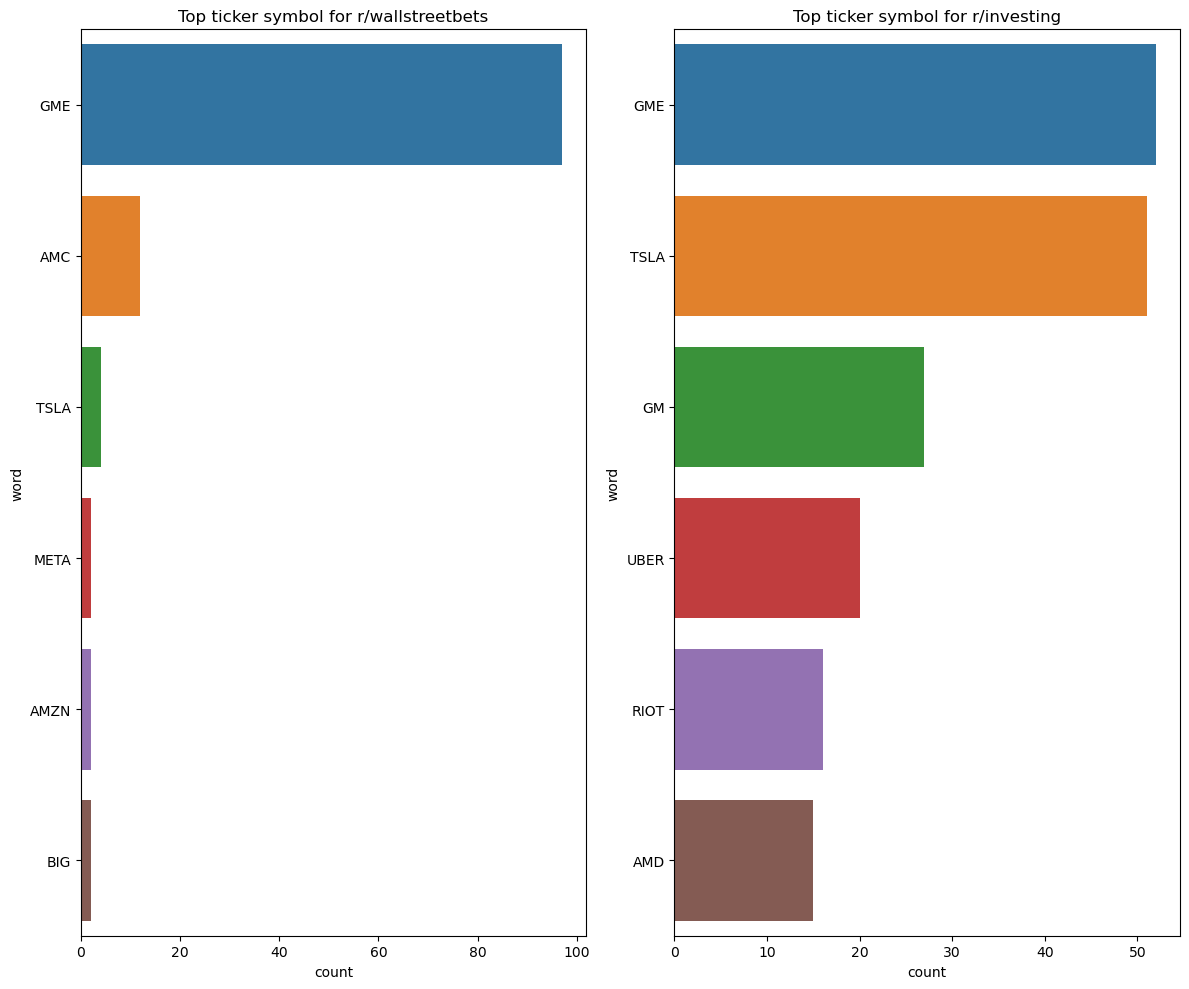

In [192]:
# Plot a horizontal bar chart for 

fig, (ax_wsb, ax_invt) = plt.subplots(nrows = 1, ncols = 2, figsize = (12,10))

# Plotting bar chart for r/wallstreetbets
sns.barplot(data = wsb_top6, y = 'word', x = 'count', ax = ax_wsb)

# Plotting bar chart for r/investing
sns.barplot(data = invt_top6, y = 'word', x = 'count',  ax = ax_invt)

ax_wsb.set(title = 'Top ticker symbol for r/wallstreetbets')
ax_invt.set(title = 'Top ticker symbol for r/investing')

plt.tight_layout()

plt.show

### With this, we will be choosing the top 4 stocks from each subreddits there are overlaps of GME and TSLA for both subreddit, we will then choose the subsequent top 4 of r/investing. As such, below are the stocks that we will be taking a deeper look at

r/wallstreetbets:
1. GME
2. AMC
3. TSLA
4. META

r/investing:
1. GM
2. UBER
3. RIOT
4. AMD

# Data Import 2: Importing stocks data that we will be predicting


In [193]:
# import the 5 year historical data of each stock

# r/wallstreetbets
gme_df = pd.read_csv('../data/gme_historical.csv')
amc_df = pd.read_csv('../data/amc_historical.csv')
tsla_df = pd.read_csv('../data/tsla_historical.csv')
meta_df = pd.read_csv('../data/meta_historical.csv')

# r/investing
gm_df = pd.read_csv('../data/gm_historical.csv')
uber_df = pd.read_csv('../data/uber_historical.csv')
riot_df = pd.read_csv('../data/riot_historical.csv')
amd_df = pd.read_csv('../data/amd_historical.csv')

In [194]:
gme_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,$22.85,1671991,$23.10,$23.10,$22.53
1,07/24/2023,$23.04,2970433,$22.42,$23.04,$22.20
2,07/21/2023,$22.18,3167916,$23.05,$23.22,$22.16
3,07/20/2023,$22.91,2256659,$23.01,$23.22,$22.66
4,07/19/2023,$23.17,2250133,$23.42,$23.58,$22.96


In [195]:
gme_df.isnull().sum().sort_values(ascending = False)

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [196]:
print(gme_df[gme_df.duplicated()])

Empty DataFrame
Columns: [Date, Close/Last, Volume, Open, High, Low]
Index: []


In [197]:
gme_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [198]:
# To remove the $ sign and change the datatypes into float

def clean_data(df):
    for col in ["Close/Last", "Open", "High", "Low"]:
        df[col] = df[col].str.replace("$", "").astype(float)

In [199]:
clean_data(gme_df)

In [200]:
gme_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,22.85,1671991,23.10,23.10,22.53
1,07/24/2023,23.04,2970433,22.42,23.04,22.20
2,07/21/2023,22.18,3167916,23.05,23.22,22.16
3,07/20/2023,22.91,2256659,23.01,23.22,22.66
4,07/19/2023,23.17,2250133,23.42,23.58,22.96


It seems that the historical stock price data extracted from Nasdaq is clean and we're good to proceed

# Preparation for Time Series Modelling

For the purpose of price prediction, we will use VWAP as the price of stock

VWAP is defined as: Volume Weighted Average Price, it is a trading benchmark that represents the average price a security traded at throughout the day, based on both volume and price.

- VWAP = (Cumulative typical price * Volume) / Culmulative Volume
- Where: Typical Price = (High Price + Low Price + Closing Price)/3

In [201]:
# Create a function that adds a new column "VWAP" to the dataframe

def calc_vwap(df):
    df["Typical_Price"] = (df["High"] + df["Low"] + df["Close/Last"])/3
    df["VWAP"] = (np.cumsum(df["Volume"] * df["Typical_Price"]) / np.cumsum(df["Volume"])).round(2)
    return df


In [202]:
# # FOR DATA FROM YAHOO FINANCE Create a function that adds a new column "VWAP" to the dataframe

# def calc_vwap(df):
#     df["Typical_Price"] = (df["High"] + df["Low"] + df["Close"])/3
#     df["VWAP"] = (np.cumsum(df["Volume"] * df["Typical_Price"]) / np.cumsum(df["Volume"])).round(2)
#     return df


In [203]:
# Generate VWAP which will be the price we will use in the time series prediction

calc_vwap(gme_df)

,Date,Close/Last,Volume,Open,High,Low,Typical_Price,VWAP
0,07/25/2023,22.8500,1671991,23.1000,23.1000,22.5300,22.826667,22.83
1,07/24/2023,23.0400,2970433,22.4200,23.0400,22.2000,22.760000,22.78
2,07/21/2023,22.1800,3167916,23.0500,23.2200,22.1600,22.520000,22.68
3,07/20/2023,22.9100,2256659,23.0100,23.2200,22.6600,22.930000,22.73
4,07/19/2023,23.1700,2250133,23.4200,23.5800,22.9600,23.236667,22.83
...,...,...,...,...,...,...,...,...
2511,08/01/2013,12.4950,16796516,12.3800,12.8400,12.3150,12.550000,16.17
2512,07/31/2013,12.2650,18825016,11.7850,12.3800,11.7850,12.143333,16.17
2513,07/30/2013,11.7275,10822960,11.3625,11.8125,11.3600,11.633333,16.17
2514,07/29/2013,11.3475,7770952,11.4175,11.4350,11.1425,11.308333,16.17


In [204]:
# Make a function that ensures that 'Date' is in datatime format
gme_df['Date'] = pd.to_datetime(gme_df['Date'])

# Set Date as the index for
gme_df.set_index("Date", inplace = True)


# def format_date(df):
#     df["Date"] = pd.to_datetime(df['Date']) ``
#     return df

In [205]:
# # MIGHT NOT NEED TO DO THIS FOR TIME SERIES

# # Creates a function that train test split but with respect to time series and dont randomize the timeline

# def timeseries_train_test_split(df, feature_col, target_col, test_size):
    
#     #Get the index after which test set starts
#     test_index = int(len(df)*(1 - test_size))

#     X = df[[feature_col]]
#     y = df[target_col]

#     X_train = X.iloc[:test_index]
#     y_train = y.iloc[:test_index]
#     X_test = X.iloc[test_index:]
#     y_test = y.iloc[test_index:]

#     return X_train, X_test, y_train, y_test

In [206]:
# # MIGHT NOT NEED TO DO THIS FOR TIME SERIES

# X_train, X_test, y_train, y_test = timeseries_train_test_split(gme_df, "Date", "VWAP", 0.25)


In [207]:
gme_df.head()

,Close/Last,Volume,Open,High,Low,Typical_Price,VWAP
Date,,,,,,,
2023-07-25,22.85,1671991,23.10,23.10,22.53,22.826667,22.83
2023-07-24,23.04,2970433,22.42,23.04,22.20,22.760000,22.78
2023-07-21,22.18,3167916,23.05,23.22,22.16,22.520000,22.68
2023-07-20,22.91,2256659,23.01,23.22,22.66,22.930000,22.73
2023-07-19,23.17,2250133,23.42,23.58,22.96,23.236667,22.83


In [208]:
gme_df = gme_df[['VWAP']]

In [209]:
gme_df = gme_df.sort_index(ascending=True)

In [210]:
gme_df.head()

,VWAP
Date,
2013-07-26,16.17
2013-07-29,16.17
2013-07-30,16.17
2013-07-31,16.17
2013-08-01,16.17


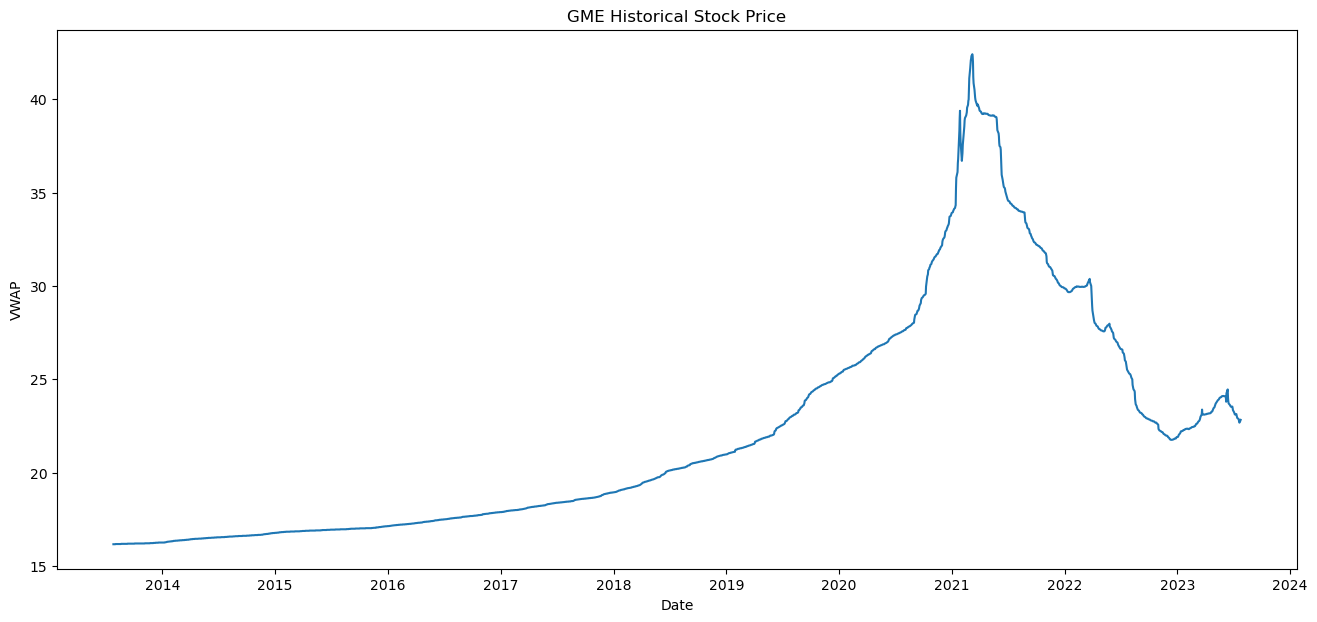

In [211]:
# plt.figure(figsize = (10, 6))
# plt.plot(gme_df['Date'], gme_df['VWAP'])
# plt.xlabel('Date')
# plt.ylabel('VWAP')
# plt.title('GME stock price of past 5 years ')
# plt.show()

# plt.figure(figsize = (10, 6))
# sns.lineplot(x = 'Date', y = 'VWAP', data = gme_df)
# sns.lineplot(x = gme_rolling_mean.index, y = 'VWAP', data = gme_rolling_mean)
# plt.title('Date vs VWAP')
# plt.show()

plt.figure(figsize = (16, 7))
sns.lineplot(x = 'Date', y = 'VWAP', data = gme_df)
plt.title('GME Historical Stock Price')
plt.show()

Checking for stationarity
- Smoothing Methods:
    1. Rolling statistics
    2. Augmented Dickey-Fuller test, ADF test

In [212]:
# To hide all the warnings 

import warnings
warnings.filterwarnings("ignore")

Rolling Average

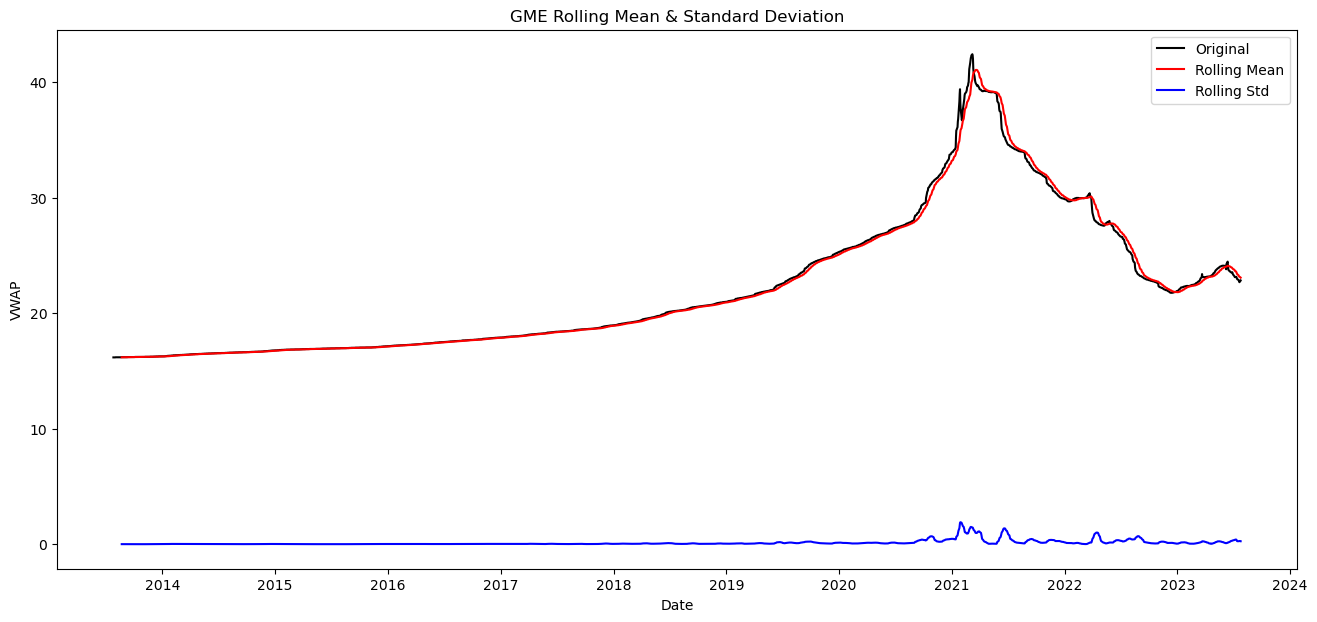

In [213]:
# Rolling average transformation

rolling_window = 20

gme_roll_mean = gme_df.rolling(rolling_window).mean()
gme_roll_std = gme_df.rolling(rolling_window).std()

# Plot the rolling statistics
plt.figure(figsize = (16,7))
fig = plt.figure(1)

orig = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_df, color = 'black', label = 'Original')
mean = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_roll_mean, color = 'red', label = 'Rolling Mean')
std = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_roll_std, color = 'blue', label = 'Rolling Std' )
plt.legend(loc = 'best')
plt.title('GME Rolling Mean & Standard Deviation')
plt.show(block = False)


Comment:

Graph of rolling mean is not constant over time, while graph of rolling standard deviation is somewhat constant

For a series to be considered stationary, both the rolling mean and rolling standard devialtion graph should be constant.

This GME series is not stationary, but we can run an adfuller test to confirm it

In [214]:
# ADF Test: Null hypothesis -> non-stationary; if p-value < 5%  -> reject null hypothesis

adfuller_result = adfuller(gme_df.VWAP.values, autolag = 'AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critical Values:')
    print(f' {key}, {value}')

ADF Statistic: -1.531157184950164
p-value: 0.5180459064440983
Critical Values:
 1%, -3.4329810529006184
Critical Values:
 5%, -2.862702382731847
Critical Values:
 10%, -2.5673887817601657


Comment: p-value is bigger than 5%, thus show that the series is not stationary

### Modifying the series to make it stationary

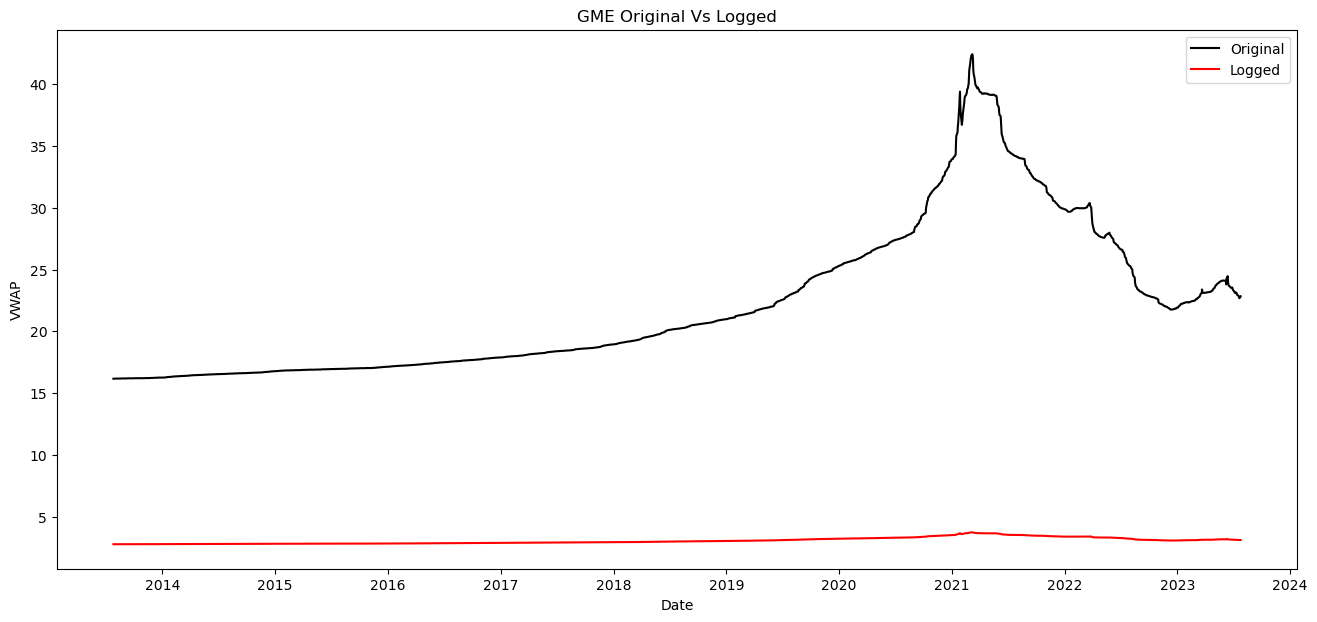

In [215]:
# Try Log transformation

gme_log = np.log(gme_df)

# Plotting the logged data against the original data to compare

plt.figure(figsize = (16,7))
fig = plt.figure(1)

orig = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_df, color = 'black', label = 'Original')
mean = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_log, color = 'red', label = 'Logged')
plt.legend(loc = 'best')
plt.title('GME Original Vs Logged')
plt.show(block = False)


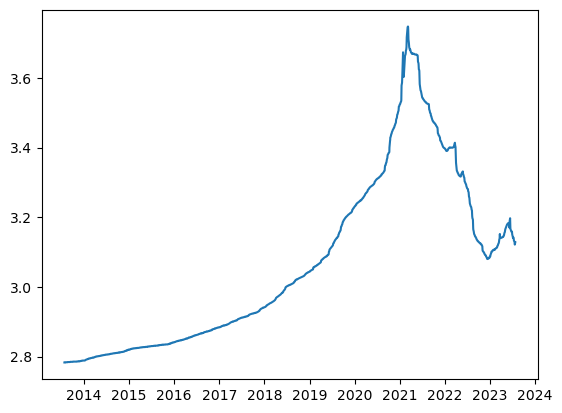

In [216]:
plt.plot(gme_log)

In [217]:
# ADF Test: Null hypothesis -> non-stationary; if p-value < 5%  -> reject null hypothesis

adfuller_result = adfuller(gme_log.VWAP.values, autolag = 'AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critical Values:')
    print(f' {key}, {value}')

ADF Statistic: -1.362079093453924
p-value: 0.60031489971199
Critical Values:
 1%, -3.4329810529006184
Critical Values:
 5%, -2.862702382731847
Critical Values:
 10%, -2.5673887817601657


Comment: Logging the data does not seem to effective, series is still not stationary based on ADF test. We will now do a decomposition to see what is affecting this series strongly

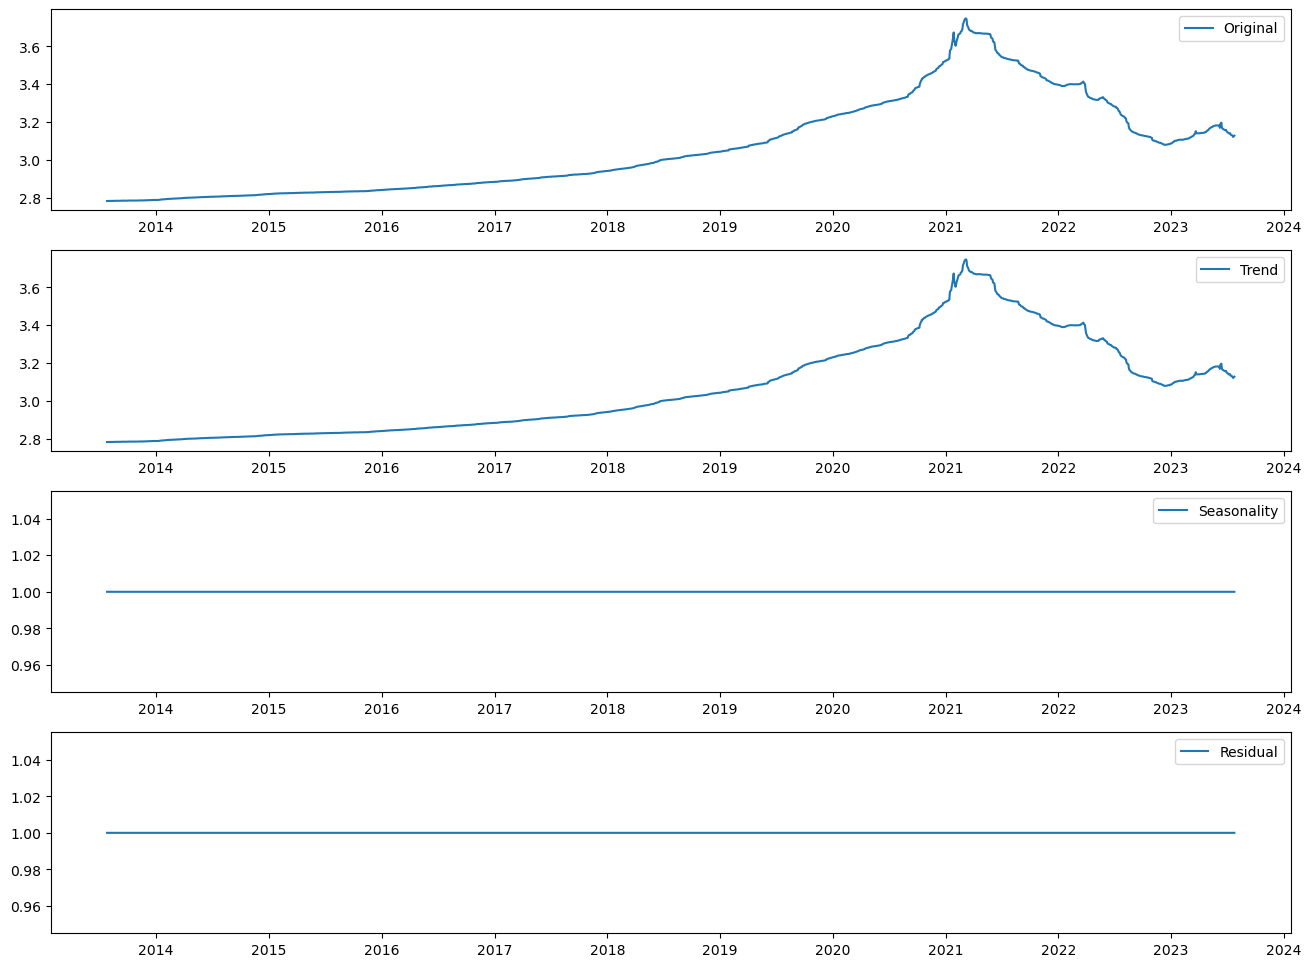

In [218]:
# Decomposition

decomposition1 = seasonal_decompose(gme_log, period = 1, model = 'multiplicative')

trend = decomposition1.trend
seasonal = decomposition1.seasonal
residual = decomposition1.resid

plt.figure(figsize= (16,12))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(gme_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

Comment: Trend component is contributing most to the original time series

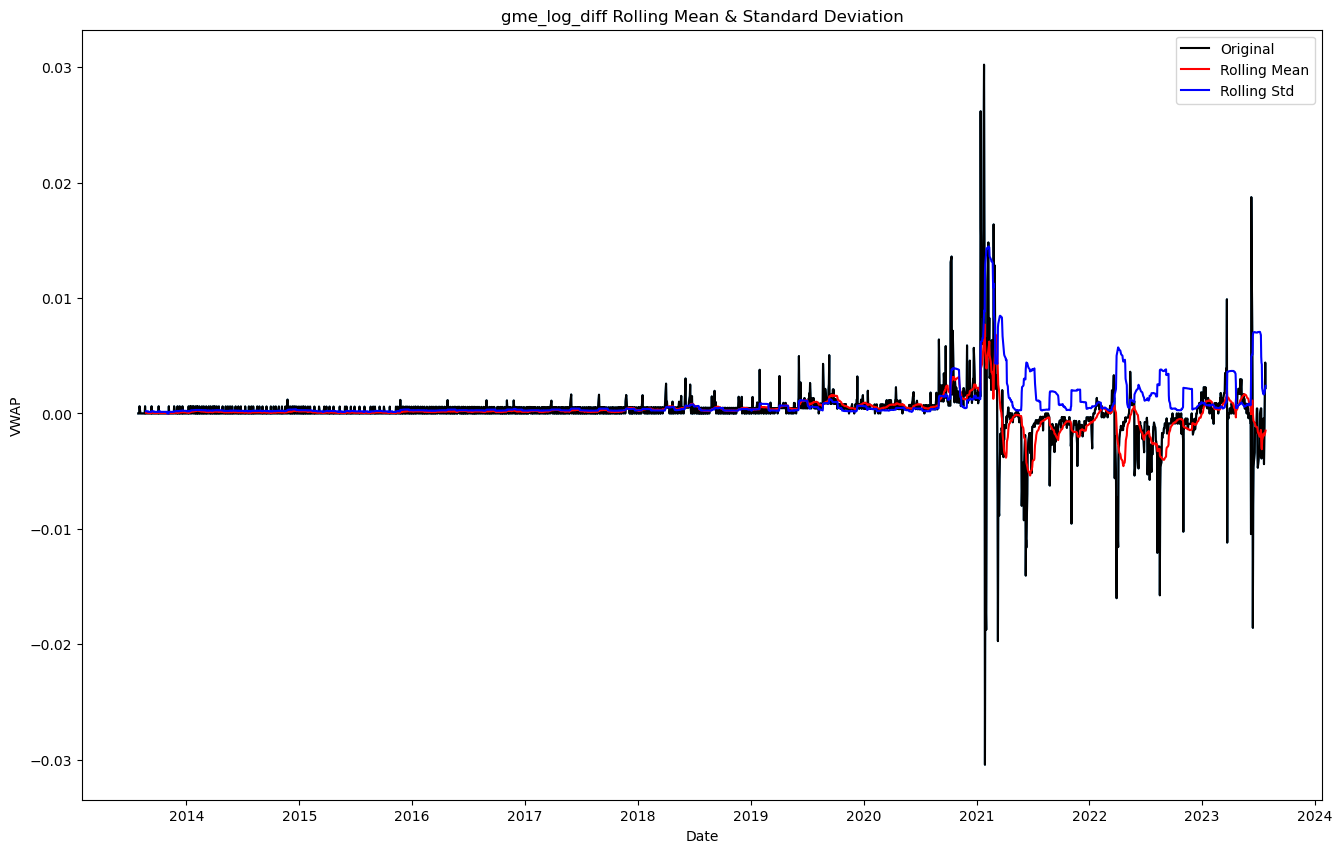

In [219]:
# Try differencing

plt.figure(figsize = (16,10))
fig = plt.figure(1)
gme_log_diff = gme_log.diff()
plt.plot(gme_log_diff)

# Determine rolling statistics
rolling_window = 20
gme_log_diff_rollmean = gme_log_diff.rolling(rolling_window).mean()
gme_log_diff_rollstd = gme_log_diff.rolling(rolling_window).std()

# Plot rolling statistics
orig = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_log_diff, color = 'black', label = 'Original')
mean = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_log_diff_rollmean, color = 'red', label = 'Rolling Mean')
std = sns.lineplot( x = 'Date', y = 'VWAP', data = gme_log_diff_rollstd, color = 'blue', label = 'Rolling Std' )
plt.legend(loc = 'best')
plt.title('gme_log_diff Rolling Mean & Standard Deviation')
plt.show(block = False)

In [220]:
gme_log_diff_test = gme_log_diff.replace([np.inf, -np.inf], np.nan)
gme_log_diff_test = gme_log_diff_test.dropna()

adfuller_result = adfuller(gme_log_diff_test.VWAP.values, autolag = 'AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critical Values:')
    print(f' {key}, {value}')

ADF Statistic: -4.914495063282924
p-value: 3.267811855364358e-05
Critical Values:
 1%, -3.4329821119179256
Critical Values:
 5%, -2.862702850392563
Critical Values:
 10%, -2.5673890307492004


In [221]:
# gme_df.sort_index(inplace= True)

In [222]:
lag_acf = acf(gme_log_diff, nlags = 20)
lag_pacf = pacf(gme_log_diff, nlags = 20)

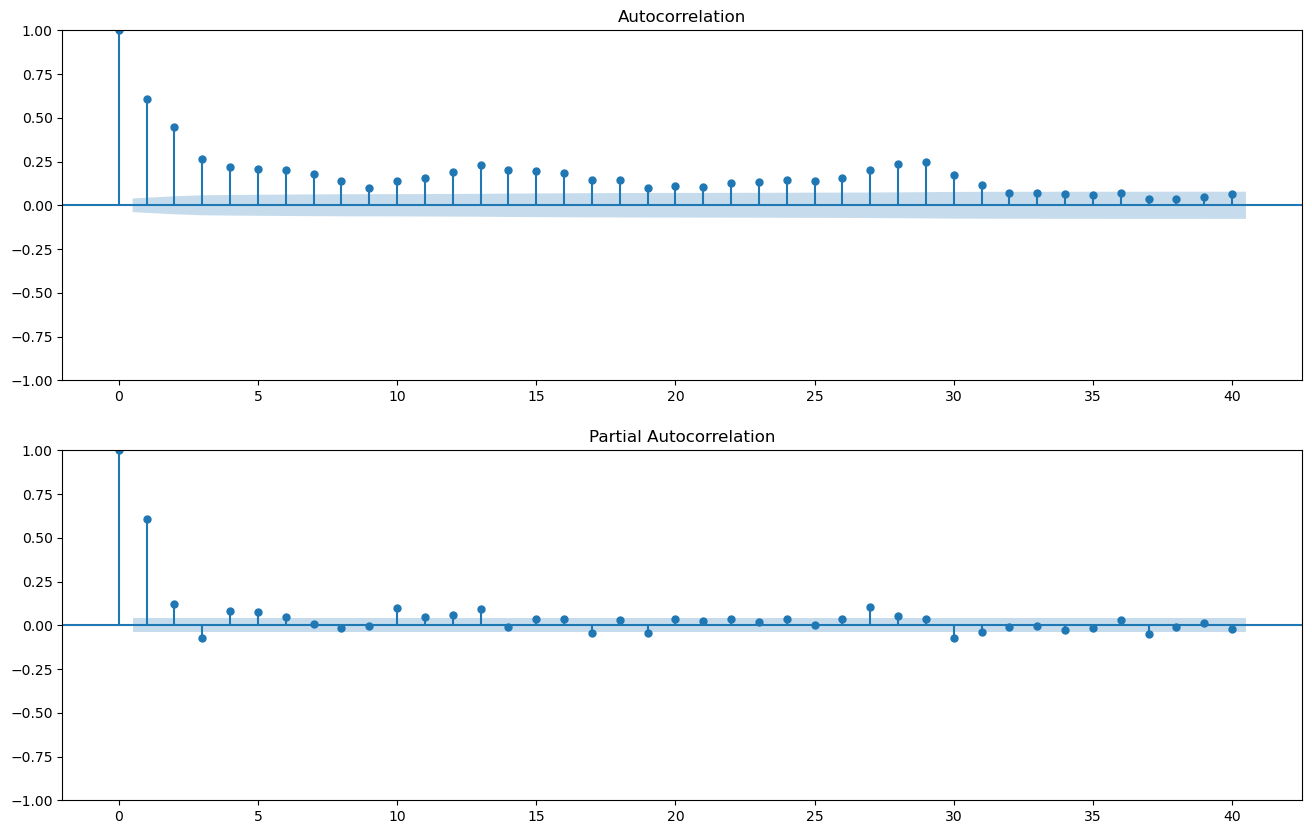

In [223]:
fig = plt.figure(figsize = (16, 10))
ax1 = fig.add_subplot (211)
fig = sm.graphics.tsa.plot_acf(gme_log_diff.dropna(), lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(gme_log_diff.dropna(), lags = 40, ax = ax2)

In [224]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
simple_pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))]

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['pdq', 'pdqs', 'aic'])

# Keep track of the lowest AIC and parameters
lowest_aic = np.inf
lowest_pdq = None
lowest_pdqs = None

print('Parameter combinations for Seasonal ARIMA...')

# Generate model for each combination of parameters
for param in simple_pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(gme_log_diff['VWAP'],
                                            order=param, 
                                            seasonal_order=param_seasonal
                                            )

            results = mod.fit(disp=0)

            # Update if current model has lower AIC than the previous lowest
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                lowest_pdq = param
                lowest_pdqs = param_seasonal
                
            # Append current iteration results to results_df
            results_df = results_df.append({'pdq': param, 'pdqs': param_seasonal, 'aic': results.aic}, ignore_index=True)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

print('The lowest AIC is {} for model SARIMAX{}x{}'.format(lowest_aic, lowest_pdq, lowest_pdqs))

Parameter combinations for Seasonal ARIMA...
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-23620.910734496778
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-23697.594601051765
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-22302.664840635134
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-23472.88828939273
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-23717.693867922364
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-23676.83108959699
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-22925.383290769656
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-23308.587543807
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-24272.91694403934
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-24289.895433141057
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-22778.574474569912
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-24070.641118412364
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-24275.091810477905
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-24299.0468968791
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-23469.557746475926
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-23911.820155420115
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-24212.3274180

In [225]:
best_model = SARIMAX(gme_log_diff['VWAP'], order = (1, 0, 1), seasonal_order = (1,0,1,12)).fit(disp =  0)

print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               VWAP   No. Observations:                 2516
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               12414.094
Date:                            Fri, 28 Jul 2023   AIC                         -24818.187
Time:                                    16:18:25   BIC                         -24789.035
Sample:                                         0   HQIC                        -24807.607
                                           - 2516                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7154      0.005    132.532      0.000       0.705       0.726
ma.L1         -0.1716      0.009   

In [226]:
# plt.figure(figsize=(10,7))

# # Plot the original data
# sns.lineplot(x=gme_log_diff.index, y=gme_log_diff['VWAP'], label='VWAP')

# # Plot the forecasted values
# sns.lineplot(x=forecast_values.predicted_mean.index, y=forecast_values.predicted_mean, label='Forecasts')

# # Plot the confidence intervals
# plt.fill_between(forecast_ci.index,
#                 forecast_ci.iloc[:, 0],
#                 forecast_ci.iloc[:, 1], color='#D3D3D3', alpha=.5)

# plt.title("Forecast", size=16)
# plt.ylabel('VWAP', size=12)
# plt.xlabel('Date', size=12)
# plt.legend(loc='best', prop={'size': 12})

# # Annotations
# plt.annotate('FORECAST', xy=(1235, 82), xycoords='data', color='RED', fontsize=11)
# plt.annotate('TO', xy=(1275, 72), xycoords='data', color='RED', fontsize=11)
# plt.annotate('2030', xy=(1260, 62), xycoords='data', color='RED', fontsize=11)

# plt.show()

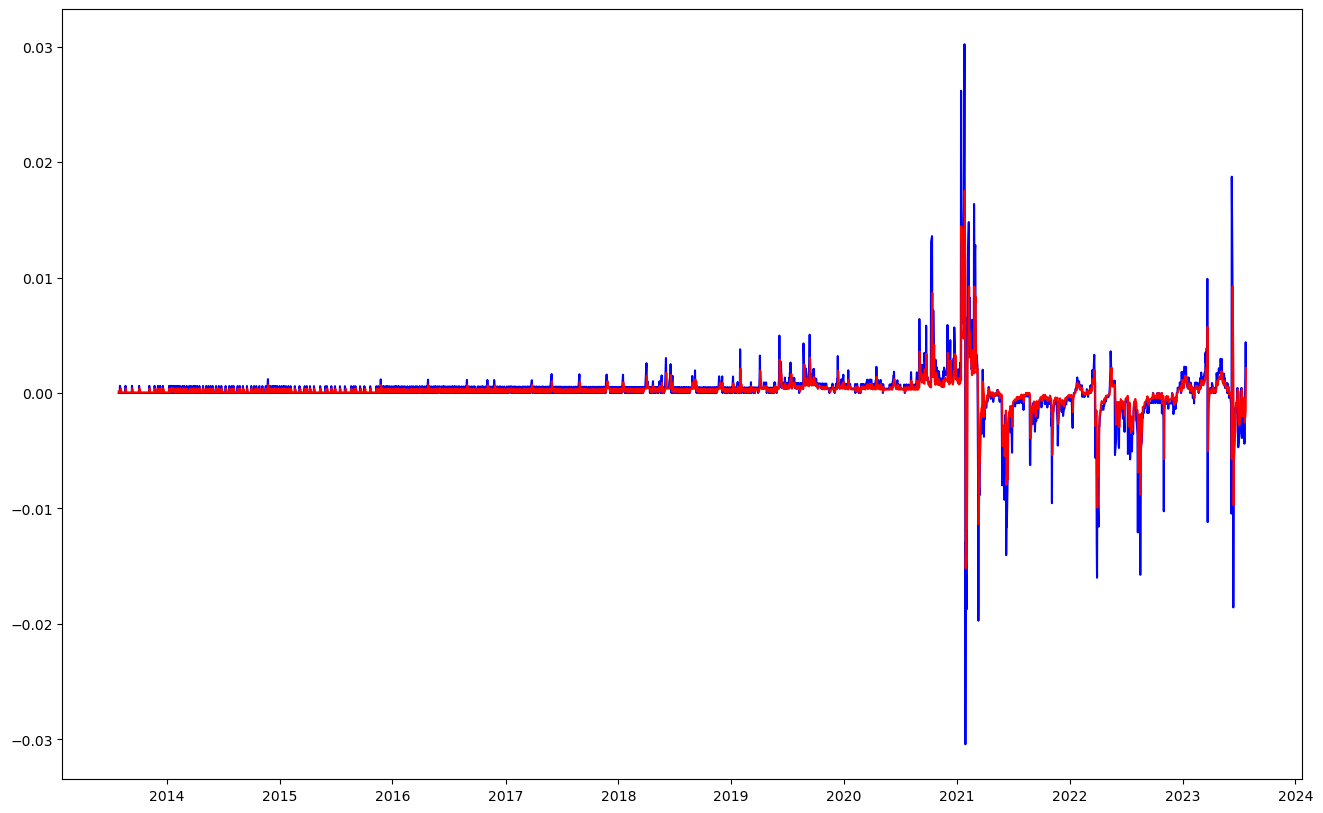

In [227]:
plt.figure(figsize= (16,10))
gme_log_diff.dropna(inplace = True)
model = ARIMA(gme_log_diff, order = (1,0,1))
results_ARIMA = model.fit()
plt.plot(gme_log_diff, color = 'blue')
plt.plot(results_ARIMA.fittedvalues, color = 'red')

Return results back to original scale

In [228]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy = True)
print(ARIMA_diff_predictions.head())

Date
2013-07-29    0.000137
2013-07-30    0.000054
2013-07-31    0.000048
2013-08-01    0.000048
2013-08-02    0.000047
dtype: float64


In [229]:
# reversing the diff()

ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()

In [230]:
ARIMA_log_prediction = pd.Series(gme_log.iloc[0], index = gme_log.index)
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum, fill_value=0)
ARIMA_log_prediction.head()

Date
2013-07-26         NaN
2013-07-29    0.000137
2013-07-30    0.000191
2013-07-31    0.000239
2013-08-01    0.000287
dtype: float64

Text(0.5, 1.0, 'RMSE: nan')

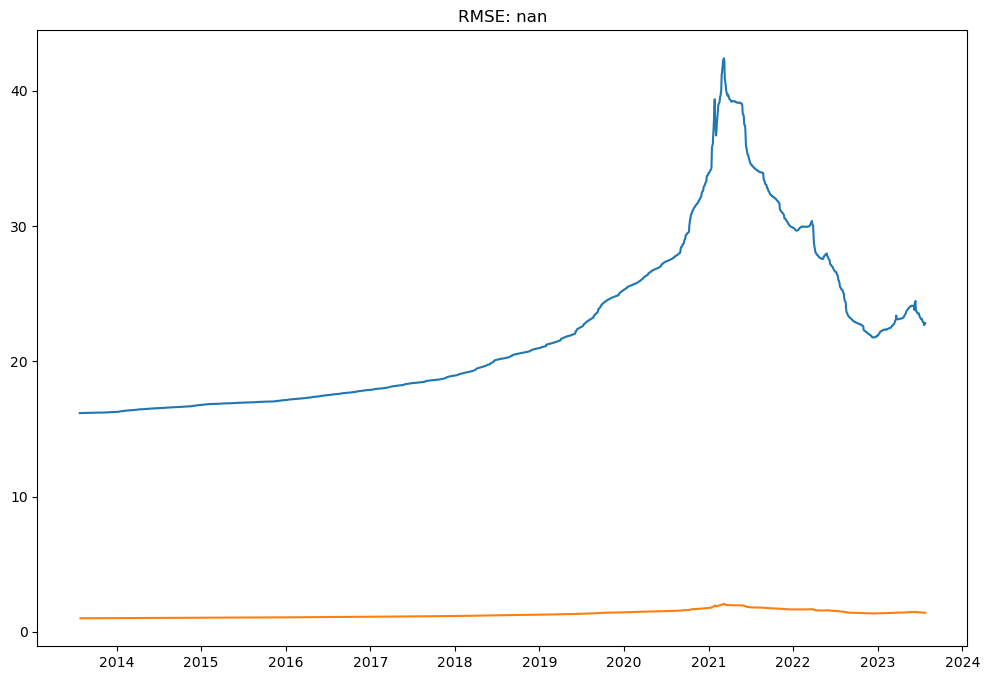

In [231]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)
plt.plot(gme_df['VWAP'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-gme_df['VWAP'])**2)/len(gme_df['VWAP'])))

In [232]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(
        timeseries, 
        start_p = 3,
        start_q = 3,
        max_p = 5,
        max_q = 5,
        test = "adf",
        seasonal = True,
        trace = True
    )
    return automodel

In [235]:
best_model = arimamodel(gme_log_diff)

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-24865.710, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-23628.626, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-24783.474, Time=0.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-24278.610, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-23620.911, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-24870.024, Time=0.78 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-24861.779, Time=1.12 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-24830.943, Time=0.67 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-24865.839, Time=1.66 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-24825.416, Time=1.01 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-24867.823, Time=0.88 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-24816.130, Time=1.20 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-24855.522, Time=0.97 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-24872.602, Time=0.39 sec
 ARIM

KeyError: 0

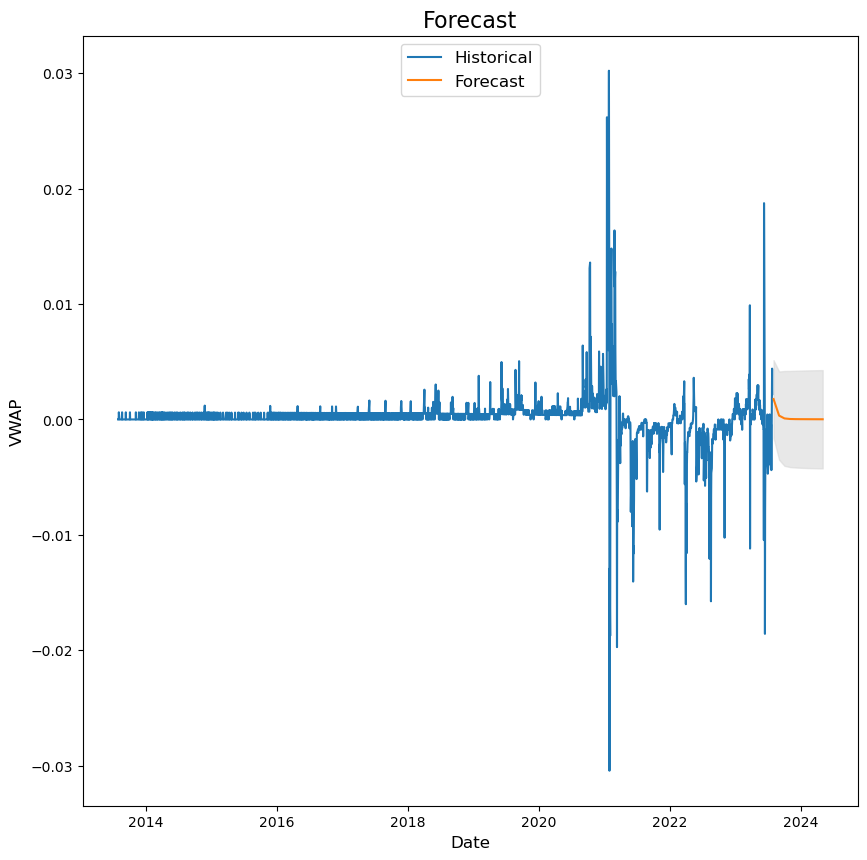

In [238]:
# The number of periods to forecast
n_periods = 10

# The forecasted values
forecast_values, conf_int = best_model.predict(n_periods=n_periods, return_conf_int=True)

# Create a range of future dates that is the length of the forecasts
future_dates = pd.date_range(gme_log_diff.index[-1], periods=n_periods, freq='MS')

# Plot the data
plt.figure(figsize=(10,10))
plt.plot(gme_log_diff.index, gme_log_diff['VWAP'], label='Historical')

# Plot the forecasted values
plt.plot(future_dates, forecast_values, label='Forecast')

# Plot the confidence intervals
plt.fill_between(future_dates, 
                 conf_int[:, 0],
                 conf_int[:, 1], color='#D3D3D3', alpha = .5)

plt.title("Forecast", size=16)
plt.ylabel('VWAP', size=12)
plt.xlabel('Date', size=12)
plt.legend(loc='upper center', prop={'size': 12})

#annotation
plt.text(future_dates[0], forecast_values[0], 'FORECAST', fontsize=11,  color='RED')
plt.text(future_dates[-1], forecast_values[-1], 'TO', fontsize=11,  color='RED')
plt.text(future_dates[-1], forecast_values[-1], '2030', fontsize=11,  color='RED')

plt.show()